In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.signal import savgol_filter as sf
from scipy.stats import linregress
from scipy.optimize import curve_fit
from shapely.geometry import mapping

In [3]:
import route_dynamics.route_elevation.base as base
from route_dynamics.route_visualizer import visualizer as vis

Put the data you want to use into the /data folder.

In [4]:
route_pts = '../data/rt40_pts.shp'

In [5]:
route = gpd.read_file(route_pts) #reads the .shp file

We know that the points are 6 ft apart, so we will had a route length column to the data frame.

In [6]:
x = []

for i in route.index:
    
    x.append(i*6)
    

route['length'] = x

In [7]:
route.head(10)

,Id,ORIG_FID,SHAPE_Leng,Z,ROUTE_NUM,geometry,length
0,0,1,0.441175,260.453505,40,POINT (-122.327137081 47.70168429900008),0
1,0,1,0.441175,260.313710,40,POINT (-122.3271363789257 47.70165989277399),6
2,0,1,0.441175,260.206556,40,POINT (-122.3271455110832 47.70163764078868),12
3,0,1,0.441175,260.048542,40,POINT (-122.3271563518966 47.70161576309354),18
4,0,1,0.441175,259.963559,40,POINT (-122.32716719271 47.7015938853984),24
5,0,1,0.441175,259.801582,40,POINT (-122.3271780335235 47.70157200770326),30
6,0,1,0.441175,259.700473,40,POINT (-122.3271888743369 47.70155013000812),36
7,0,1,0.441175,259.571199,40,POINT (-122.3271997151503 47.70152825231299),42
8,0,1,0.441175,259.415655,40,POINT (-122.3272105559637 47.70150637461785),48
9,0,1,0.441175,259.237424,40,POINT (-122.3272213967771 47.70148449692271),54


Now we see the route distance.

## Pre-filter

Let's see what the data looks like before filtering.

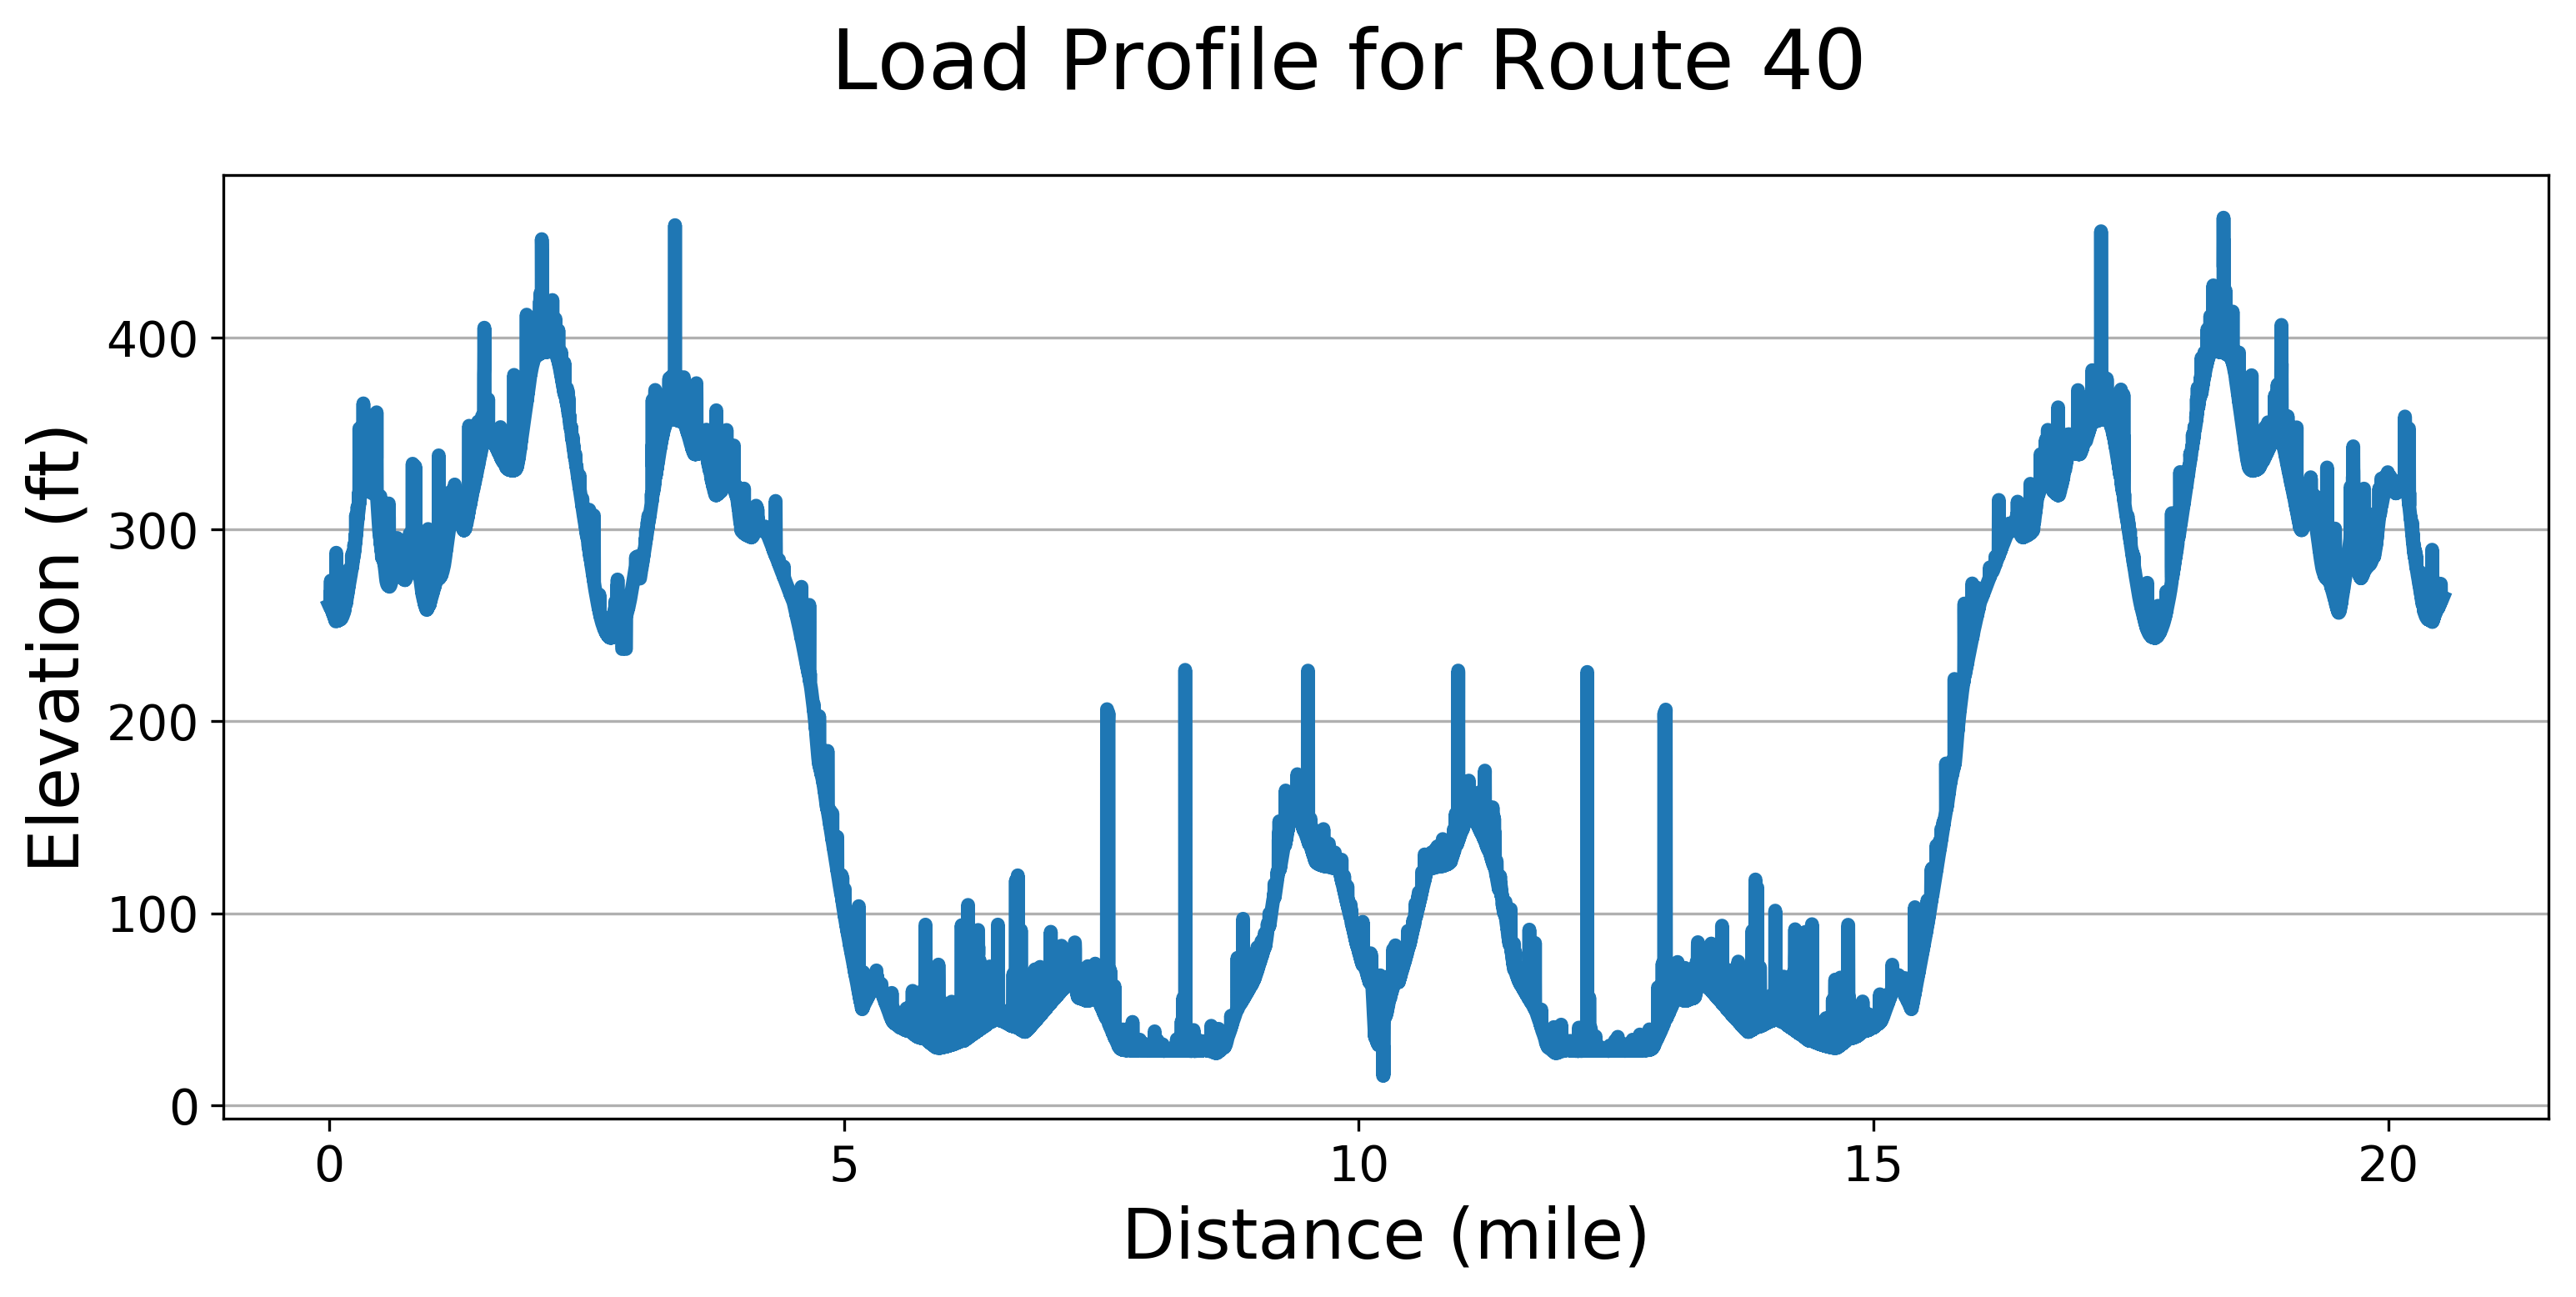

In [8]:
vis.profile_x(route['Z'], route['length'], 40)

In [9]:
#Splitting the route into out_bound and in_bound so it is easier to read
out_bound_raw, in_bound_raw = np.split(route['Z'].values, 2)

out_bound2, in_bound2 = np.split(route['length'].values, 2)

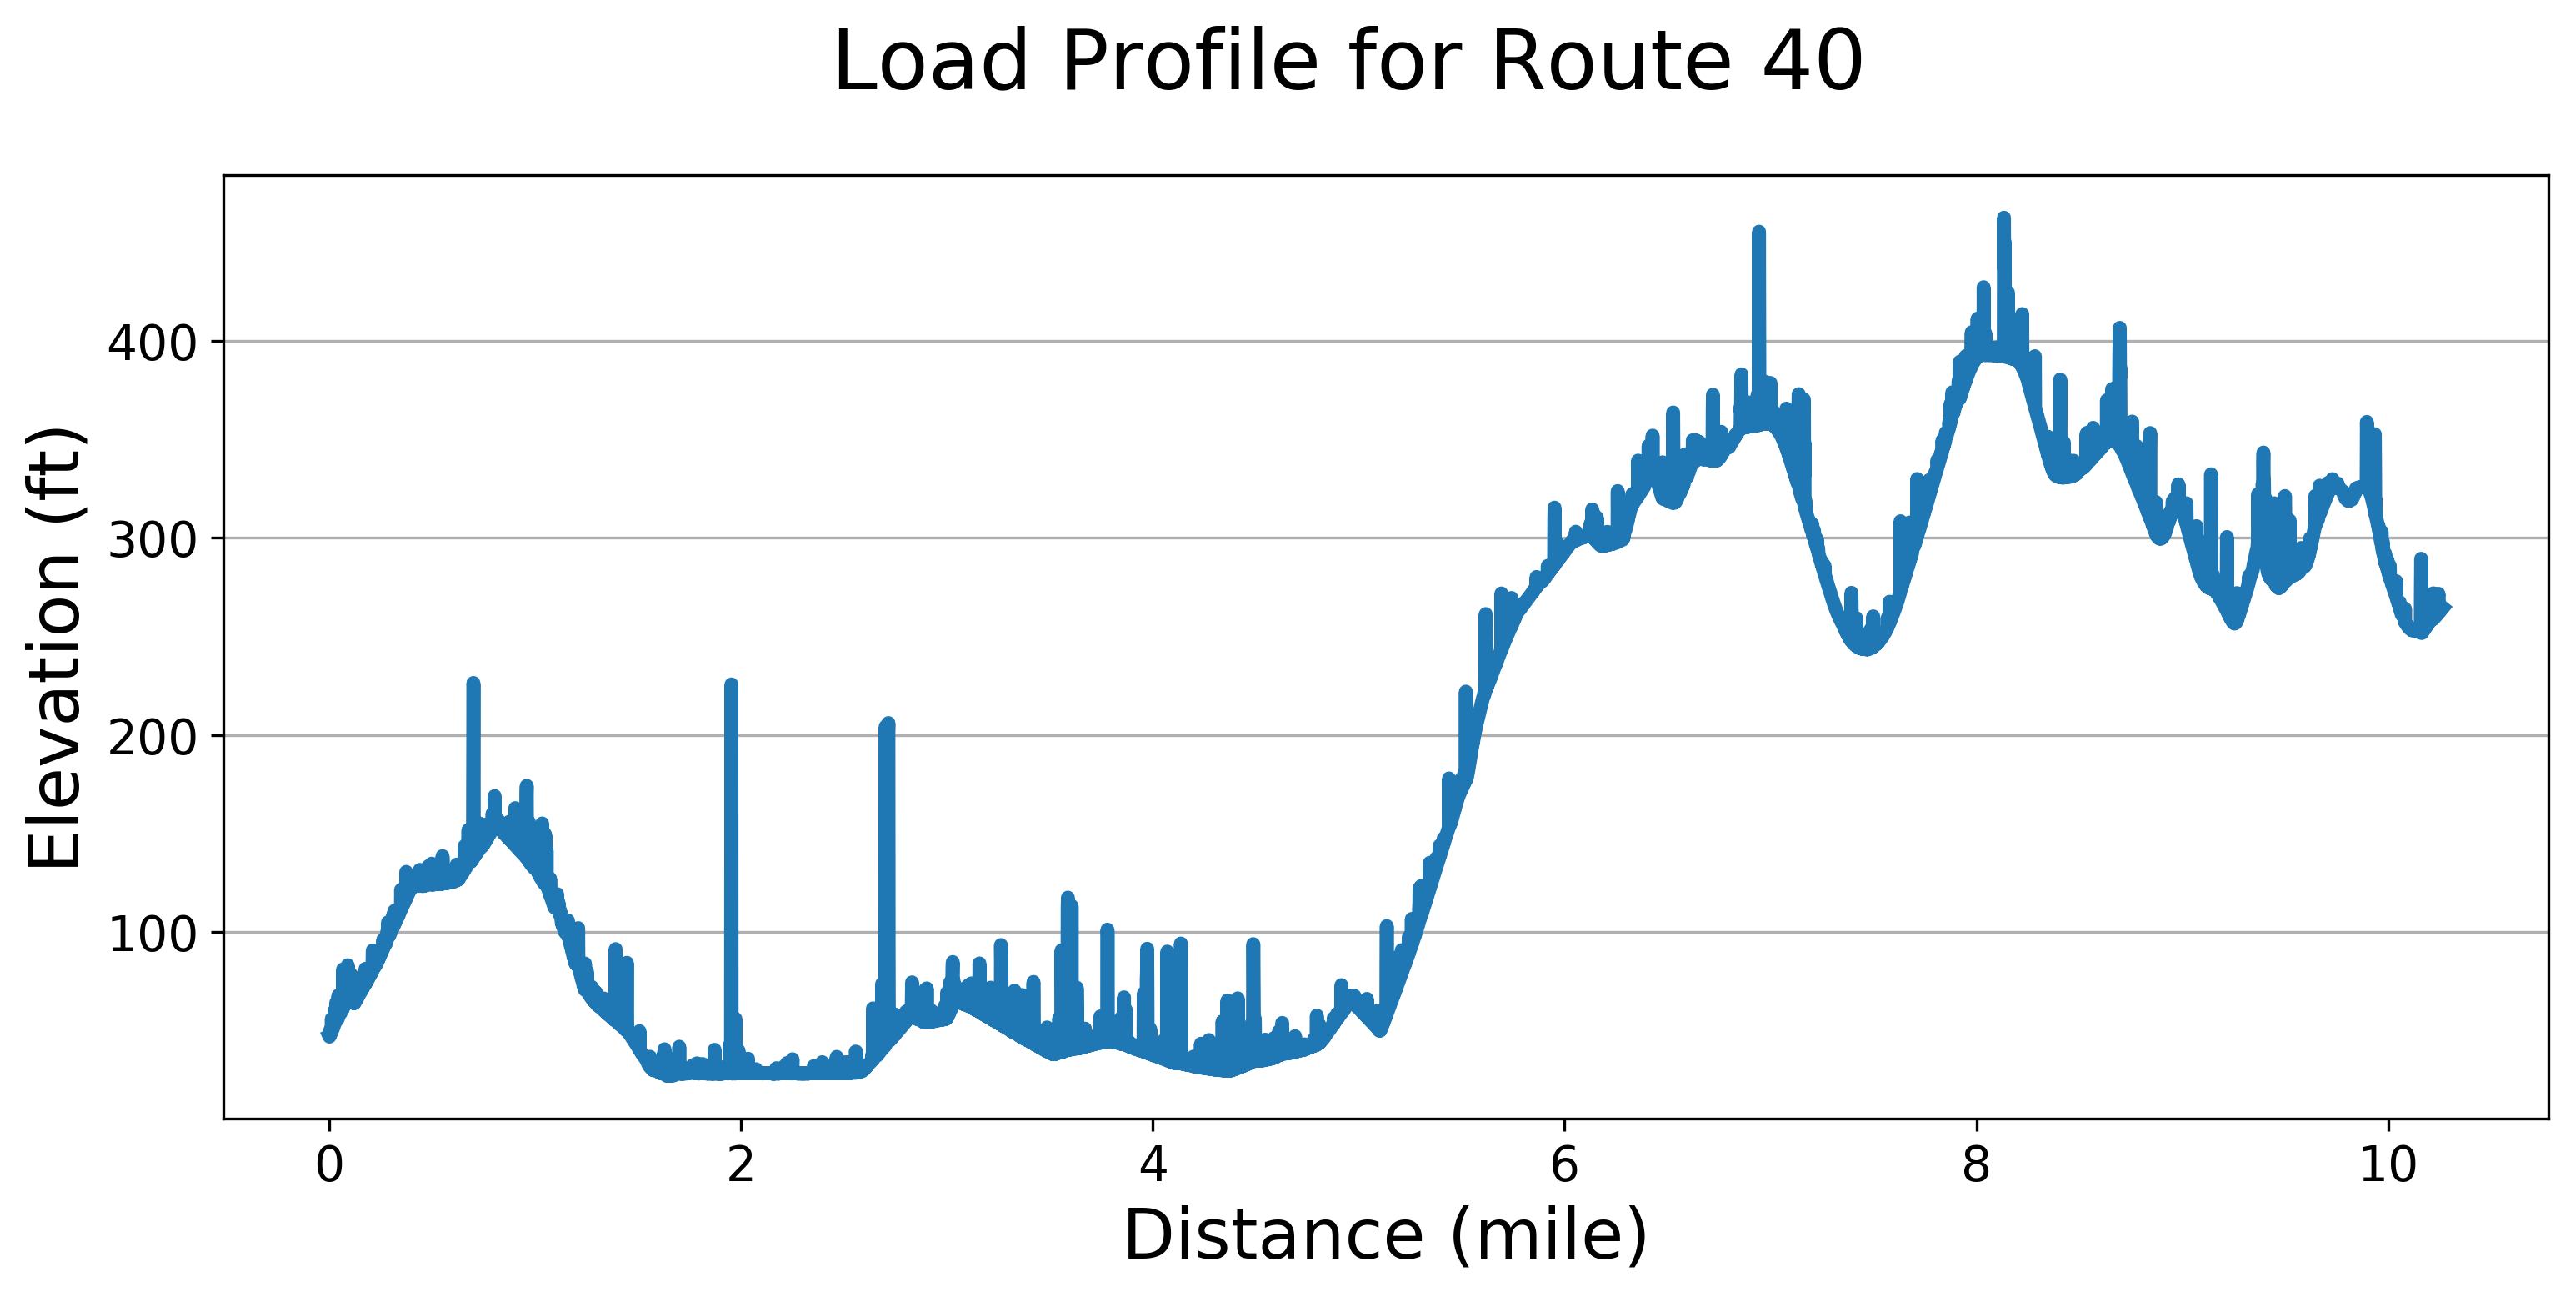

In [10]:
vis.profile_x(in_bound_raw, out_bound2, 40)

In [26]:
#Calculating the grade
points = route[('Z')].values  #new array from dataframe column

grade = [0]

for i in range(1,len(points)):
    grade.append((points[i]-points[i-1])/6)
    

#grade
route['grade']=grade
route.head(10)

,Id,ORIG_FID,SHAPE_Leng,Z,ROUTE_NUM,geometry,length,grade,grade_SG
0,0,1,0.441175,260.453505,40,POINT (-122.327137081 47.70168429900008),0,0.000000,0.000000
1,0,1,0.441175,260.313710,40,POINT (-122.3271363789257 47.70165989277399),6,-0.023299,-0.089033
2,0,1,0.441175,260.206556,40,POINT (-122.3271455110832 47.70163764078868),12,-0.017859,-0.087497
3,0,1,0.441175,260.048542,40,POINT (-122.3271563518966 47.70161576309354),18,-0.026336,-0.085968
4,0,1,0.441175,259.963559,40,POINT (-122.32716719271 47.7015938853984),24,-0.014164,-0.084446
5,0,1,0.441175,259.801582,40,POINT (-122.3271780335235 47.70157200770326),30,-0.026996,-0.082932
6,0,1,0.441175,259.700473,40,POINT (-122.3271888743369 47.70155013000812),36,-0.016851,-0.081425
7,0,1,0.441175,259.571199,40,POINT (-122.3271997151503 47.70152825231299),42,-0.021546,-0.079926
8,0,1,0.441175,259.415655,40,POINT (-122.3272105559637 47.70150637461785),48,-0.025924,-0.078434
9,0,1,0.441175,259.237424,40,POINT (-122.3272213967771 47.70148449692271),54,-0.029705,-0.076950


array([260.45350497, 260.31370993, 260.20655568, ..., 264.29377221,
       264.4940659 , 264.59666403])

## Smoothing- Just SG

How does the route look if we just use the SG filter?

Check out more documentation on SG filter:

In [13]:
y_new = sf(points, 441, 3,  axis = 0)

In [14]:
out_bound, in_bound = np.split(y_new, 2)

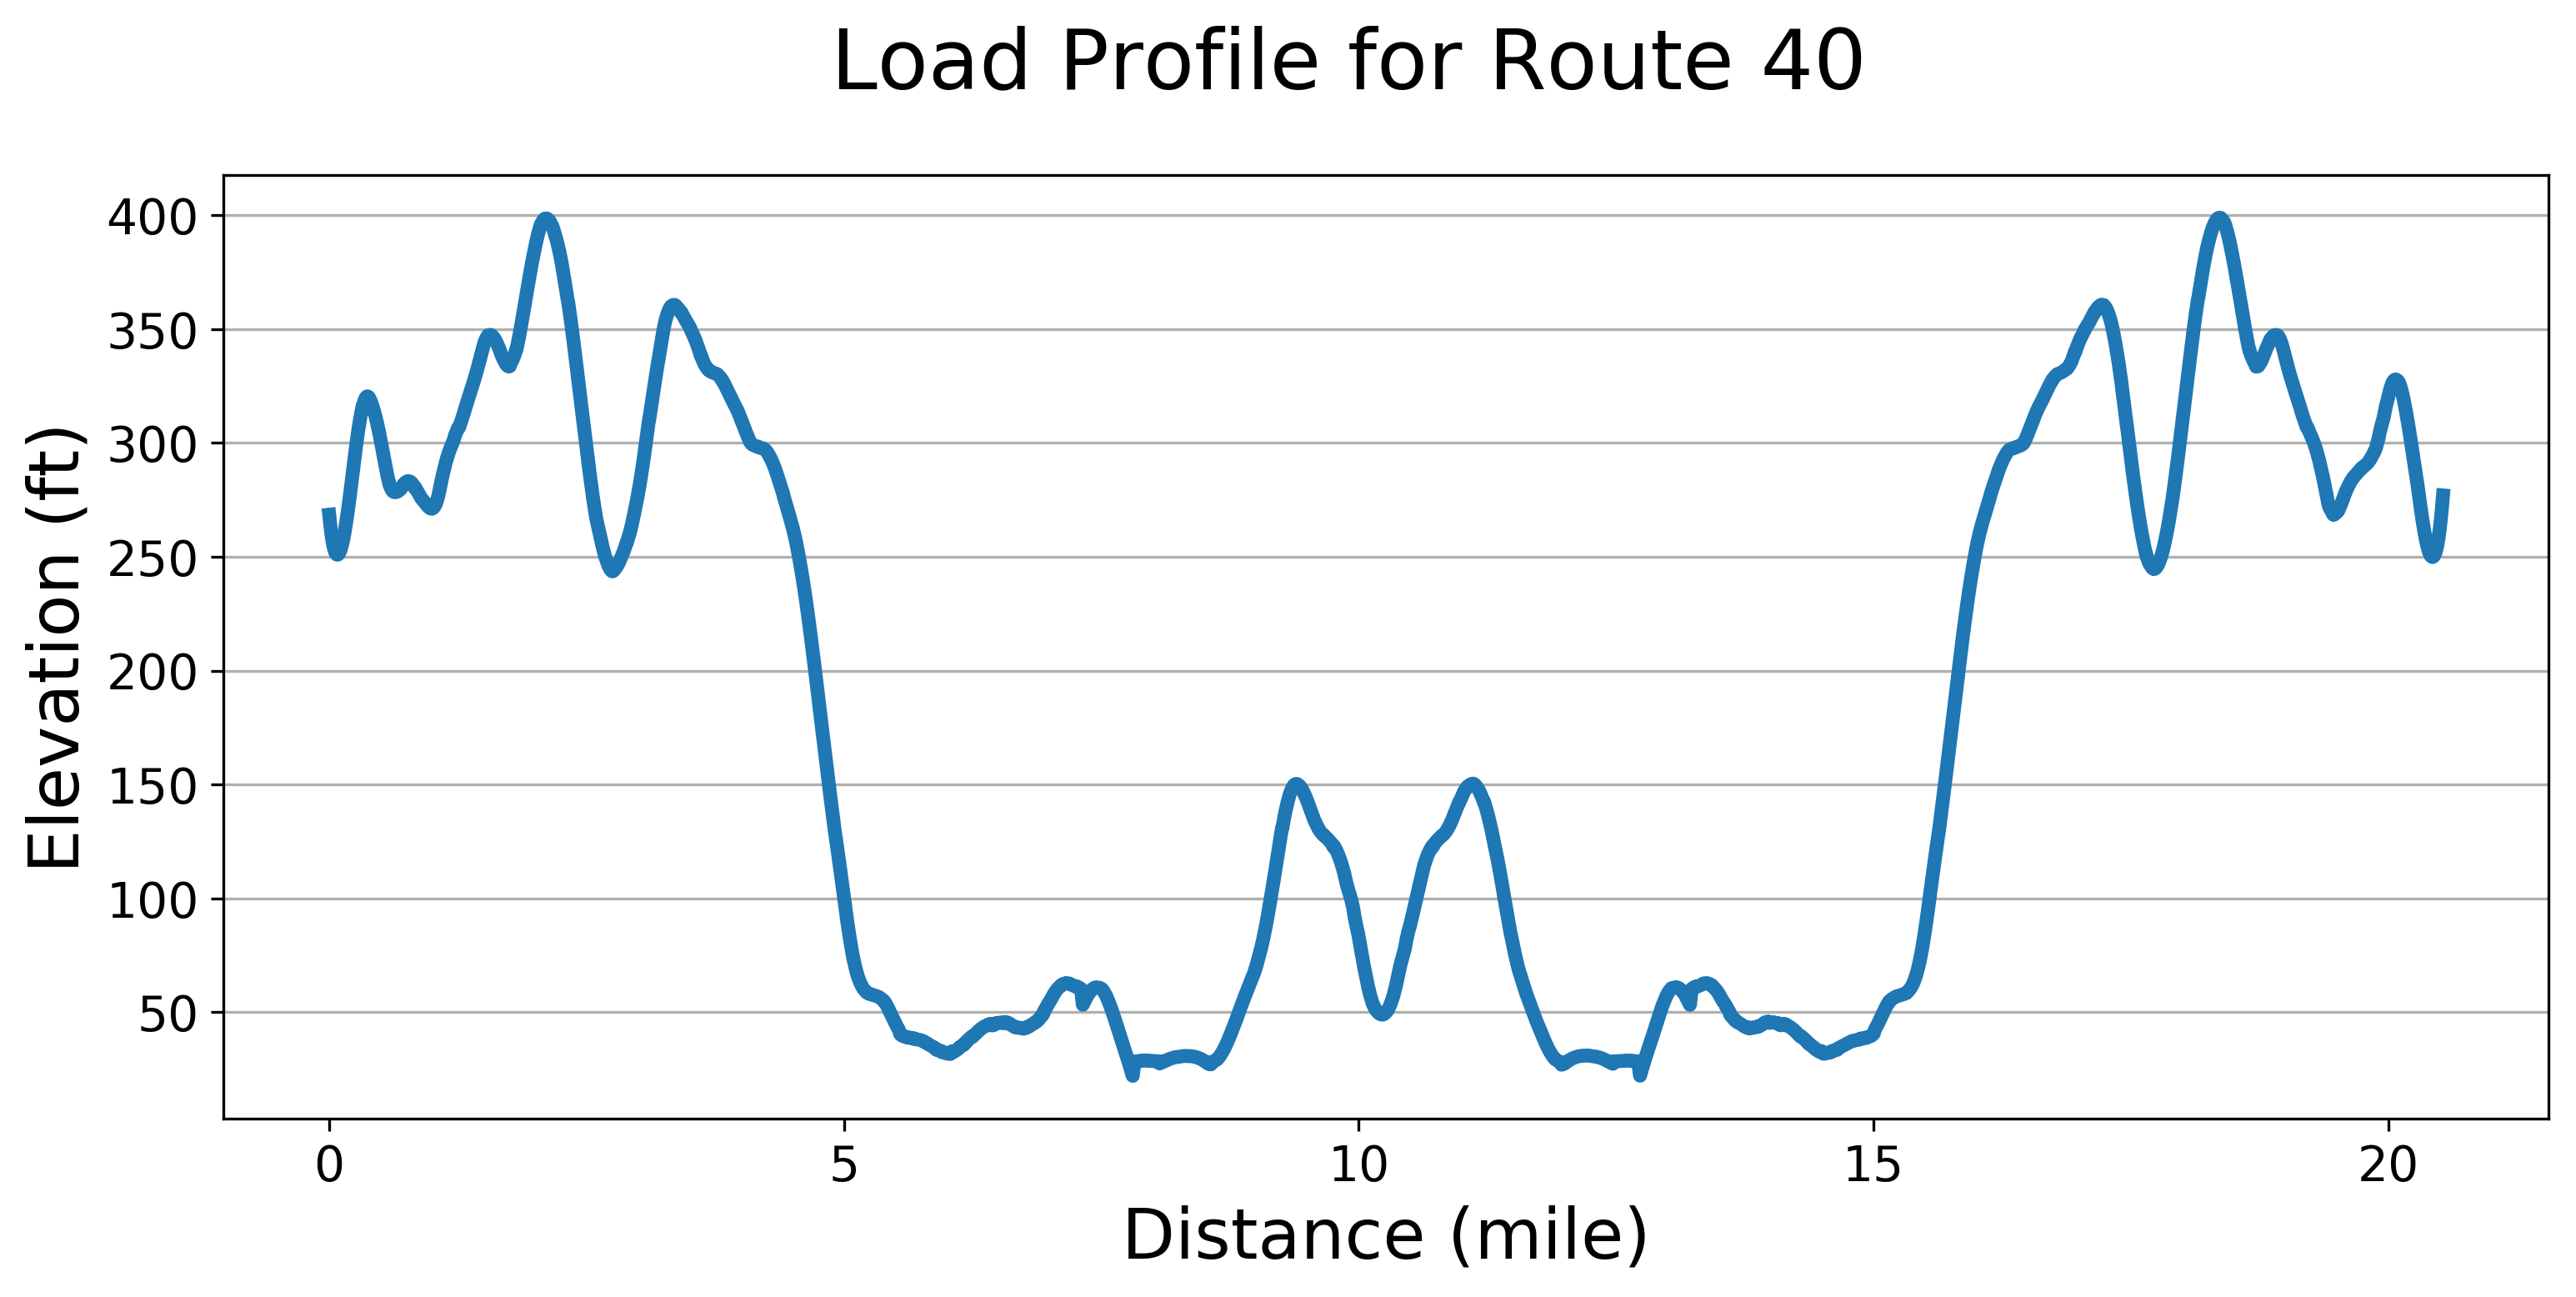

In [15]:
vis.profile_x(y_new, route['length'].values, 40)

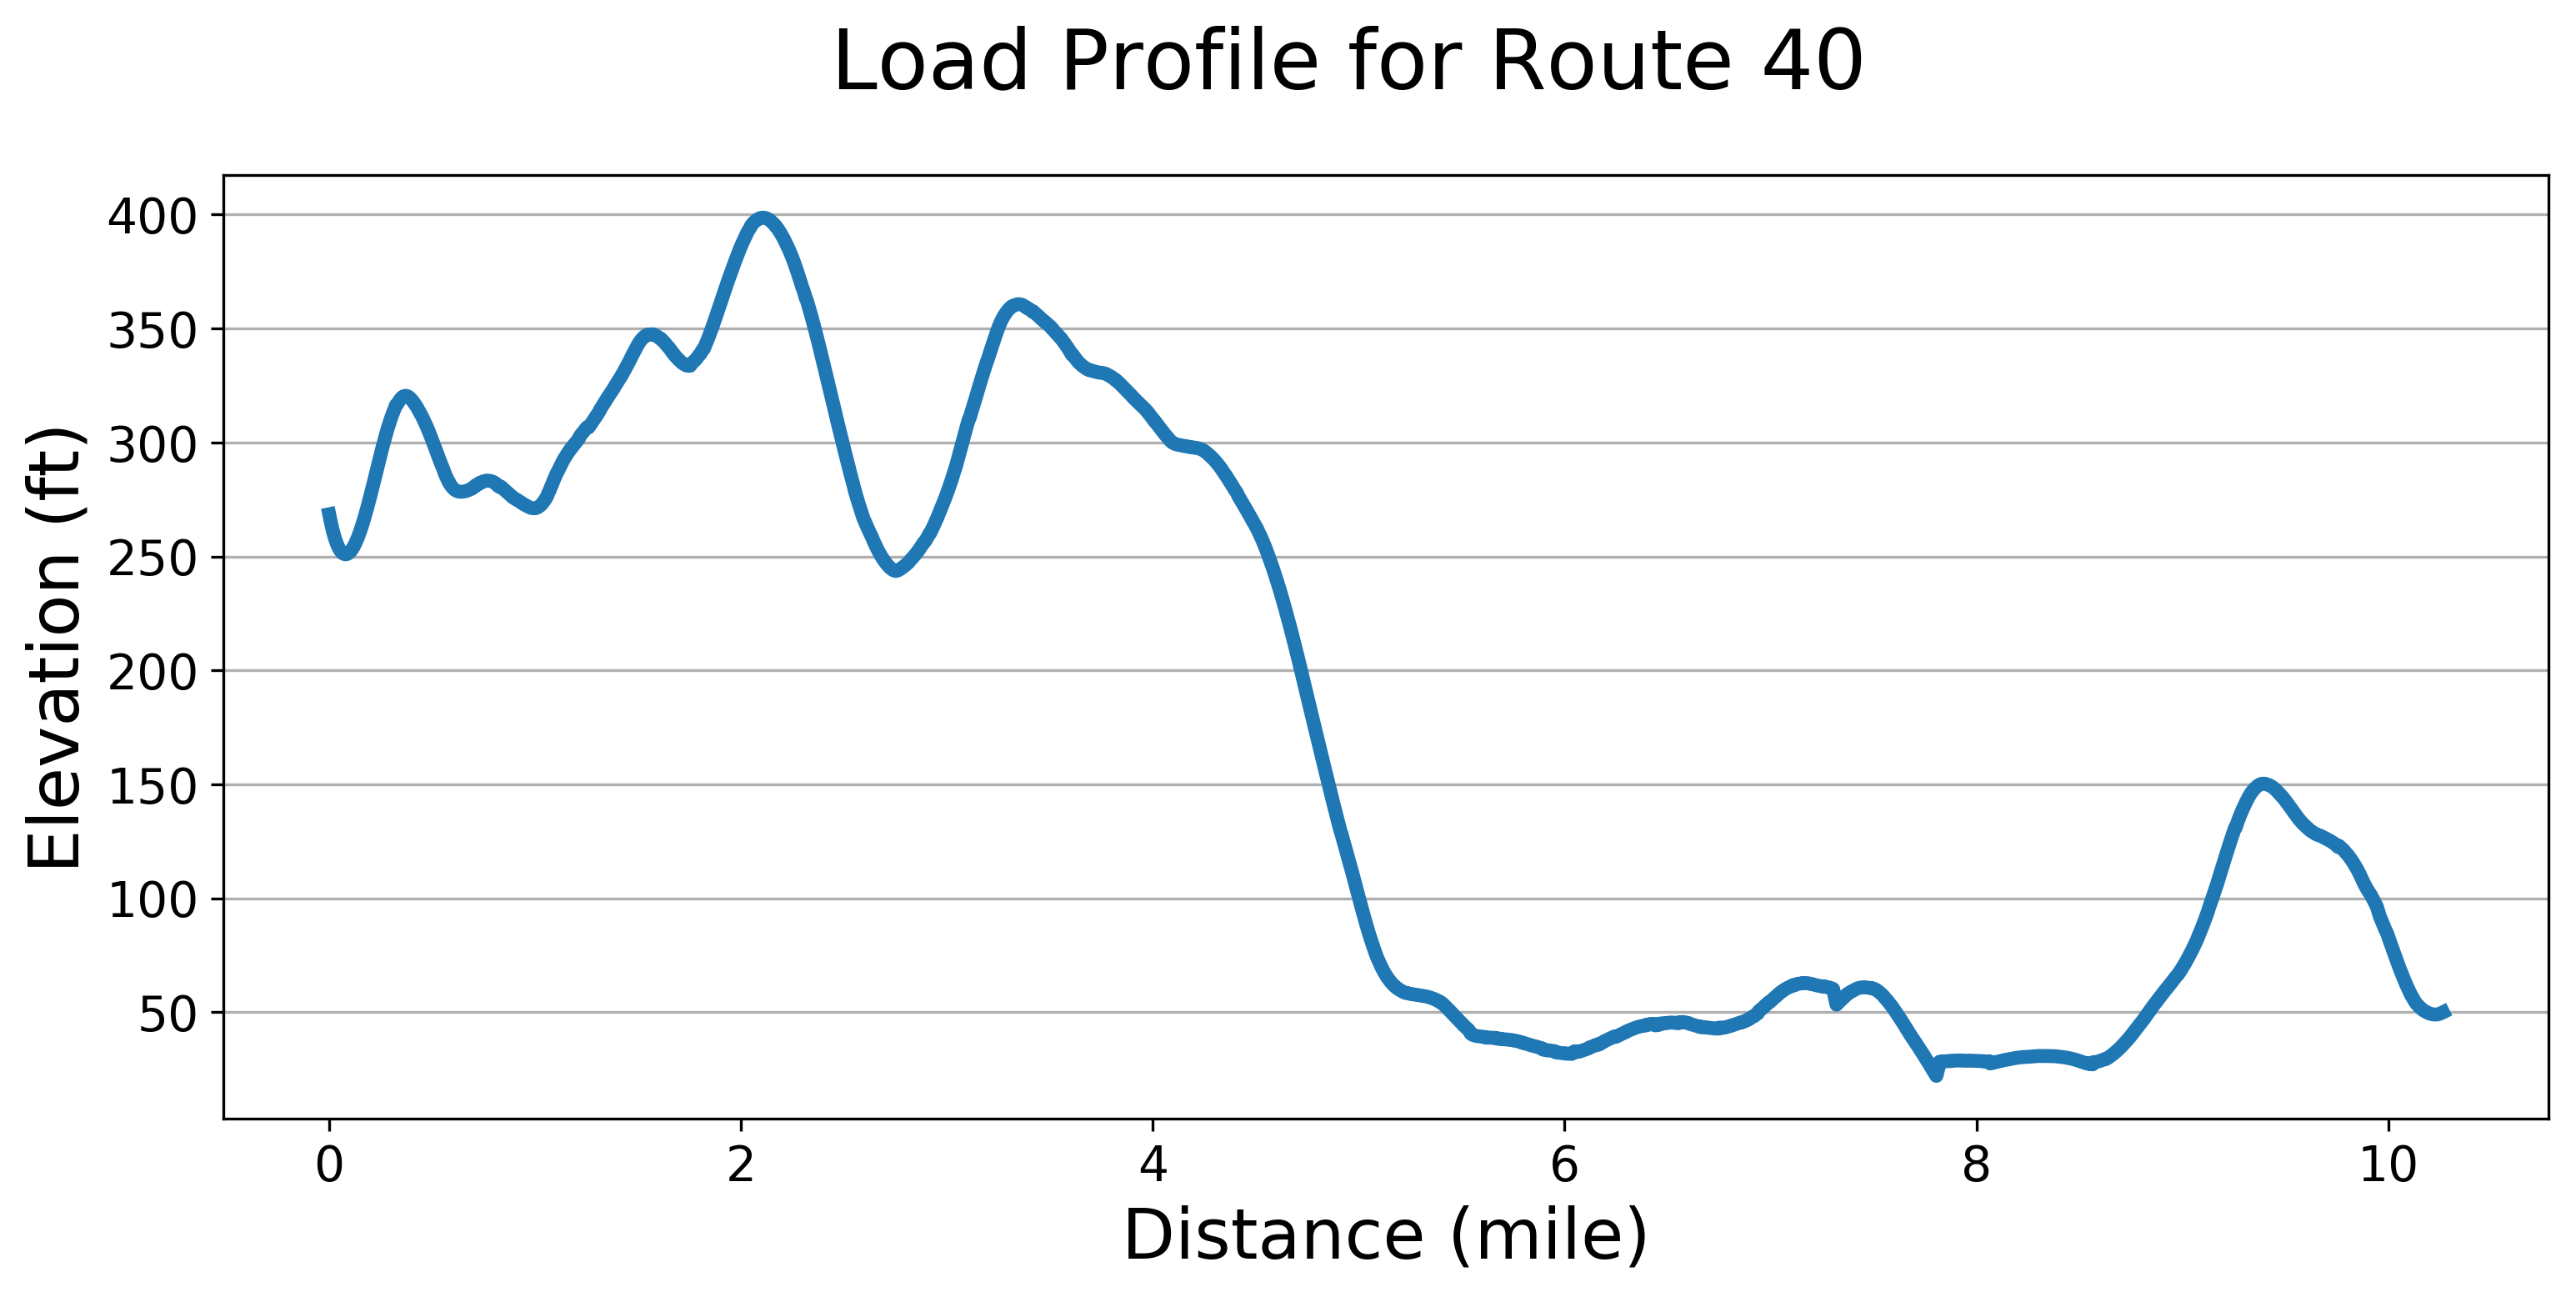

In [16]:
vis.profile_x(out_bound, out_bound2, 40)

#### Let's also check the grade.

In [29]:
grade_SG = [0]

for i in range(1,len(y_new)):
    grade_SG.append((y_new[i]-y_new[i-1])/6)
    

#grade
route['grade_SG']=grade_SG
route.head(20)

,Id,ORIG_FID,SHAPE_Leng,Z,ROUTE_NUM,geometry,length,grade,grade_SG
0,0,1,0.441175,260.453505,40,POINT (-122.327137081 47.70168429900008),0,0.000000,0.000000
1,0,1,0.441175,260.313710,40,POINT (-122.3271363789257 47.70165989277399),6,-0.023299,-0.089033
2,0,1,0.441175,260.206556,40,POINT (-122.3271455110832 47.70163764078868),12,-0.017859,-0.087497
3,0,1,0.441175,260.048542,40,POINT (-122.3271563518966 47.70161576309354),18,-0.026336,-0.085968
4,0,1,0.441175,259.963559,40,POINT (-122.32716719271 47.7015938853984),24,-0.014164,-0.084446
5,0,1,0.441175,259.801582,40,POINT (-122.3271780335235 47.70157200770326),30,-0.026996,-0.082932
6,0,1,0.441175,259.700473,40,POINT (-122.3271888743369 47.70155013000812),36,-0.016851,-0.081425
7,0,1,0.441175,259.571199,40,POINT (-122.3271997151503 47.70152825231299),42,-0.021546,-0.079926
8,0,1,0.441175,259.415655,40,POINT (-122.3272105559637 47.70150637461785),48,-0.025924,-0.078434
9,0,1,0.441175,259.237424,40,POINT (-122.3272213967771 47.70148449692271),54,-0.029705,-0.076950


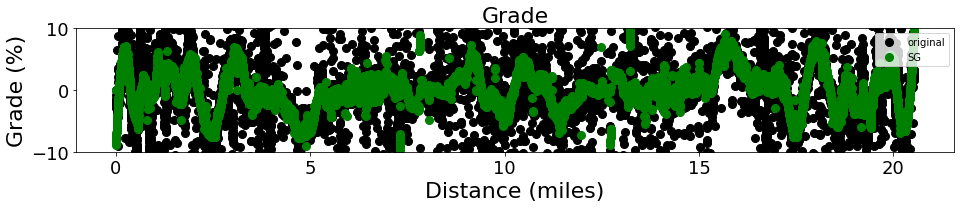

In [32]:
fig = plt.figure(figsize=(13.5,3))

ax1 = fig.add_subplot(111)
ax1.set_title('Grade',fontsize = 22)
ax1.plot((route['length'])/5280,route['grade']*100,'o',label='original',color = 'k',ms = 8)
ax1.plot((route['length'])/5280,route['grade_SG']*100,'o',label='SG',color = 'g',ms = 8)

ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.set_xlabel("Distance (miles)",fontsize = 22)
ax1.set_ylabel("Grade (%)",fontsize = 22)
ax1.legend()
ax1.set_ylim(-10,10)
plt.tight_layout()

## Smoothing- Remove outliers

In [19]:
#Polynomial fitting and derivative calculation
window=50  #Number of points per iteration
n = window // 2 #Half of Window
r2=0.95 #R2 threshold 
rmse_threshold = 0.25 #RMSE threshold (2nd order)

line = [] #Empty list for y-values of fitted points
sin = [] #Empty list for derivative
grade = [] #The grade of the fitted point

#Define functions for regression

#Define function
    
def third_order (x,param3,param2,param1,param0):
    return (param3*(x**3))+(param2*(x**2))+(param1*x) + param0 
    
def rmse(predictions, targets):
            
    differences = predictions - targets
    differences_squared = differences ** 2
    mean_of_differences_squared = differences_squared.mean()
    rmse_val=np.sqrt(mean_of_differences_squared)
            
    return rmse_val

#First, fit a line to the points that will not be in the first window
for i in range (0,n):
    tempdata = route.iloc[0:i+n]
    
    xl = tempdata['length'].values  #x values of data
    yl= tempdata['Z'].values   #y values of data
    mid_point = route["length"].iloc[i]
    
    param3, var3 = sp.optimize.curve_fit(third_order,xl,yl)
    y_value = third_order(mid_point,*param3)
    deriv = (3*param3[0]*(mid_point**2))+(2*param3[1]*mid_point)+param3[2]

            
    line.append(y_value)
    sin.append(deriv)
    grade.append(deriv*100)
            
            
        
#Now, fit a line around point i, where i is the mid-point of the window
for i in range(n,int(len(route))): 
    tempdata = route.iloc[(i-n):(i+n)] 
    
    xl = tempdata['length'].values  #x values of data
    yl= tempdata['Z'].values   #y values of data
    mid_point = route["length"].iloc[i]
            
    param3, var3 = sp.optimize.curve_fit(third_order,xl,yl)
    y_value = third_order(mid_point,*param3)      
    deriv = (3*param3[0]*(mid_point**2))+(2*param3[1]*mid_point)+param3[2]
    
    line.append(y_value)
    sin.append(deriv)
    grade.append(deriv*100)

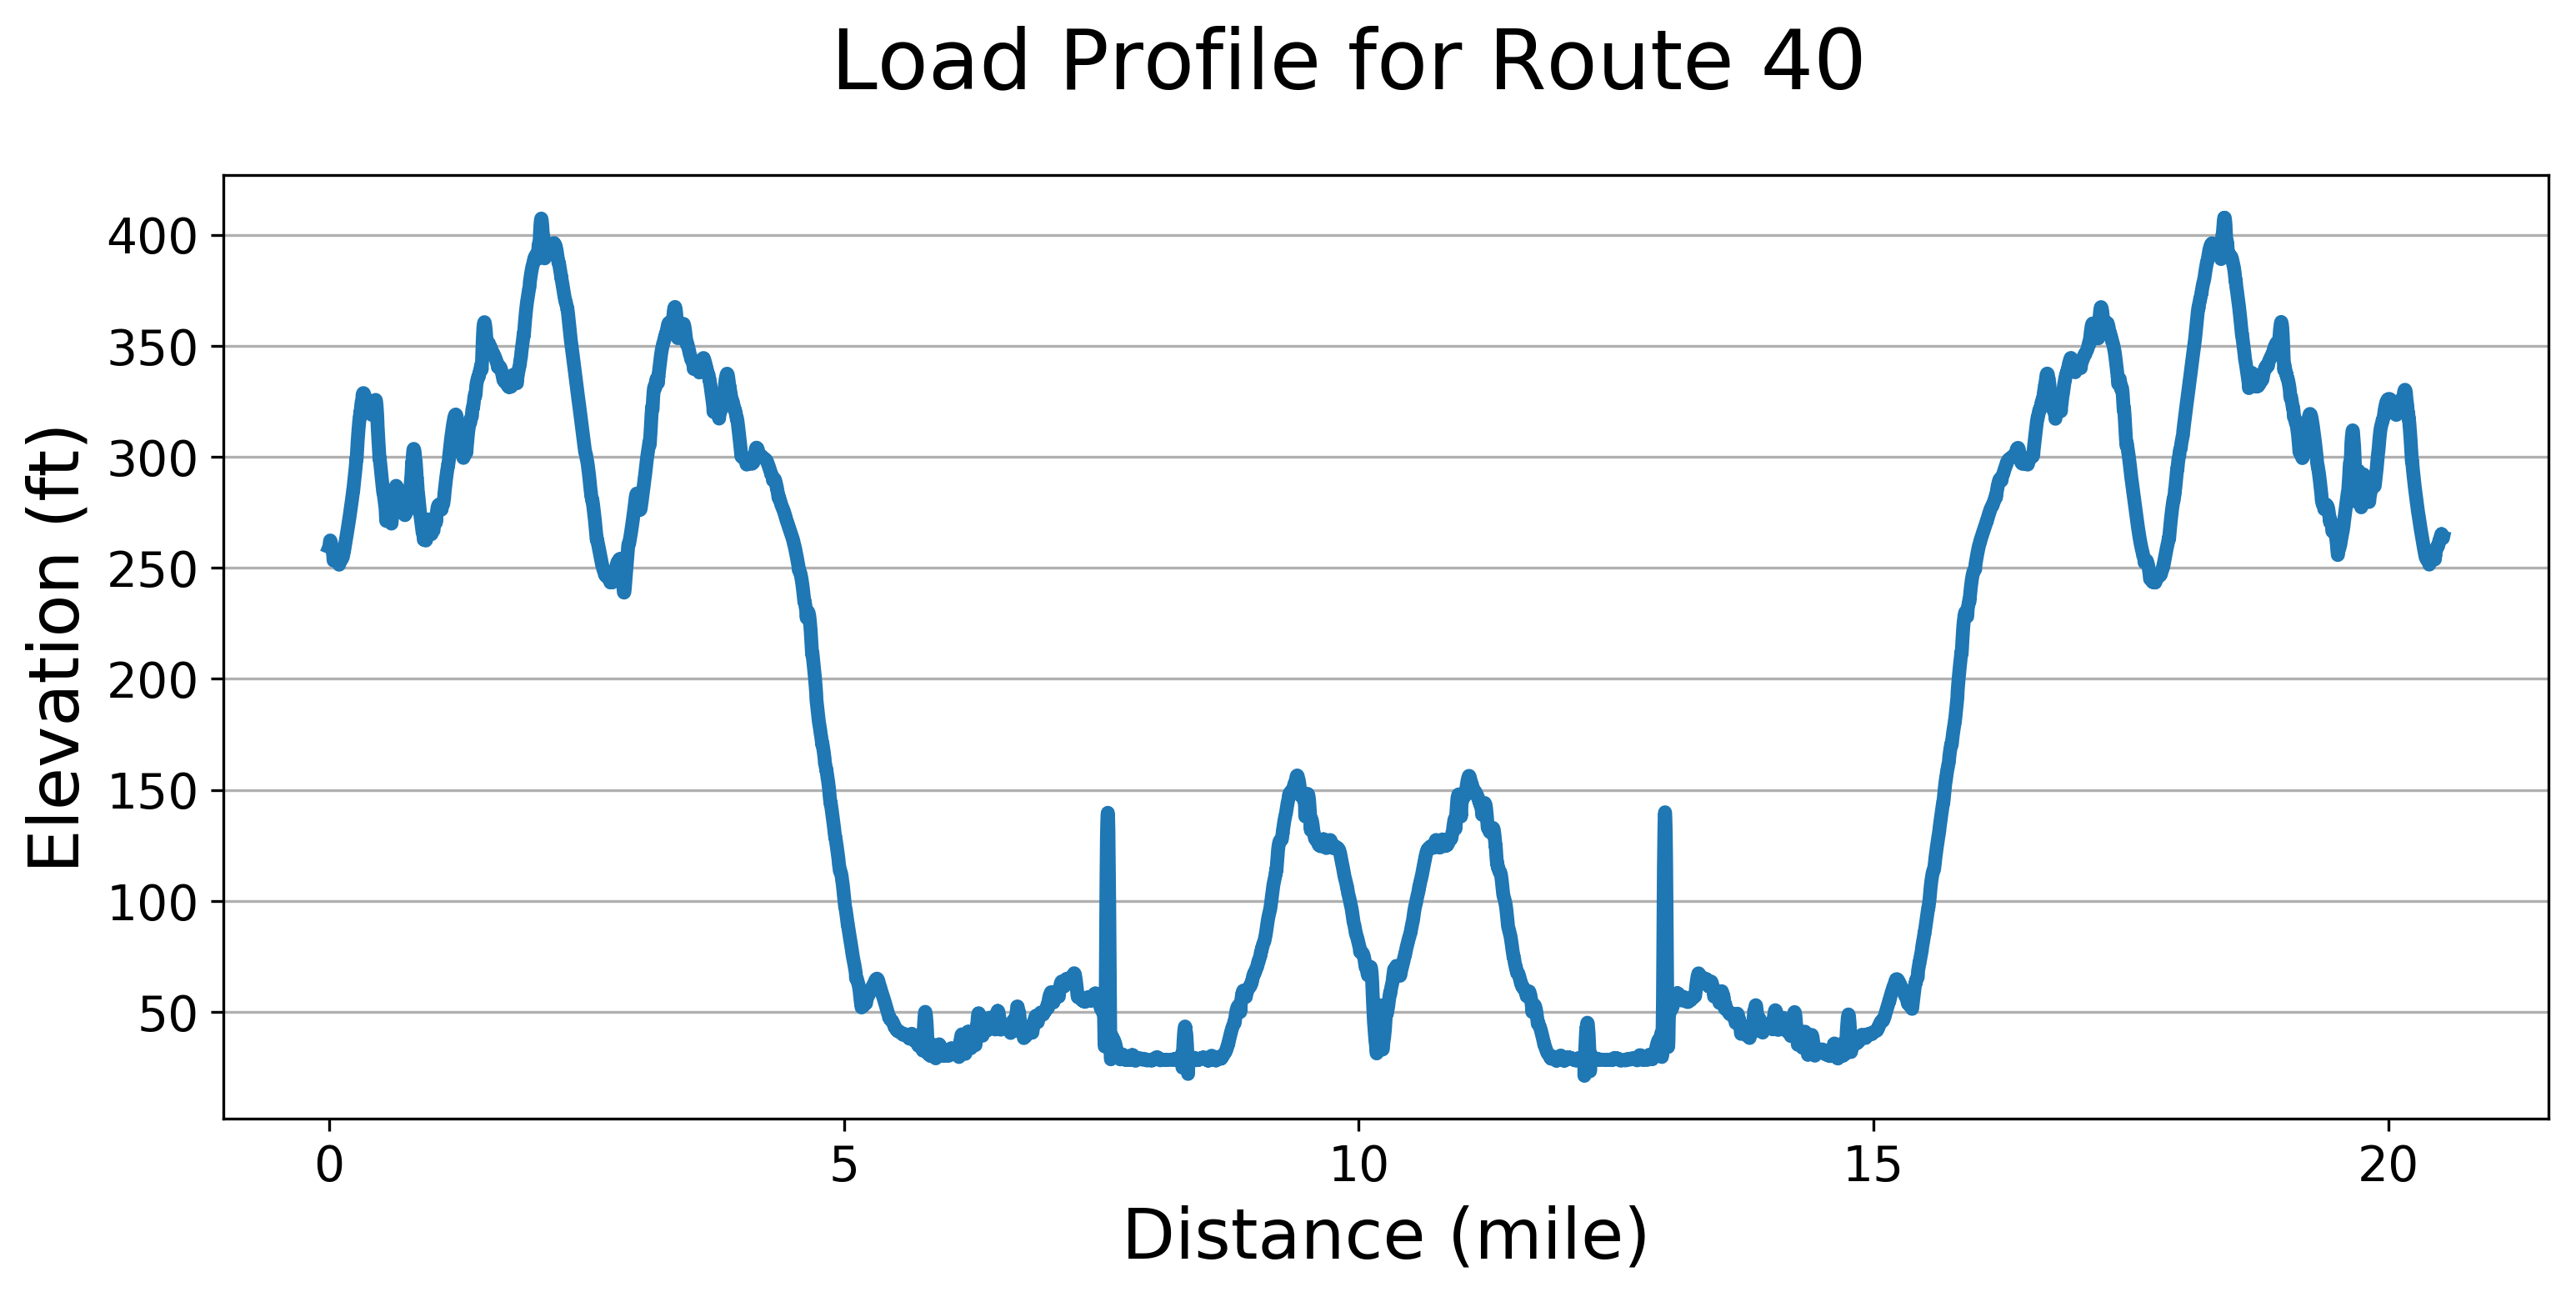

In [21]:
vis.profile_x(line, route['length'], 40)

In [35]:
y_new2 = sf(line, 441, 3,  axis = 0)

## Post-smoothing

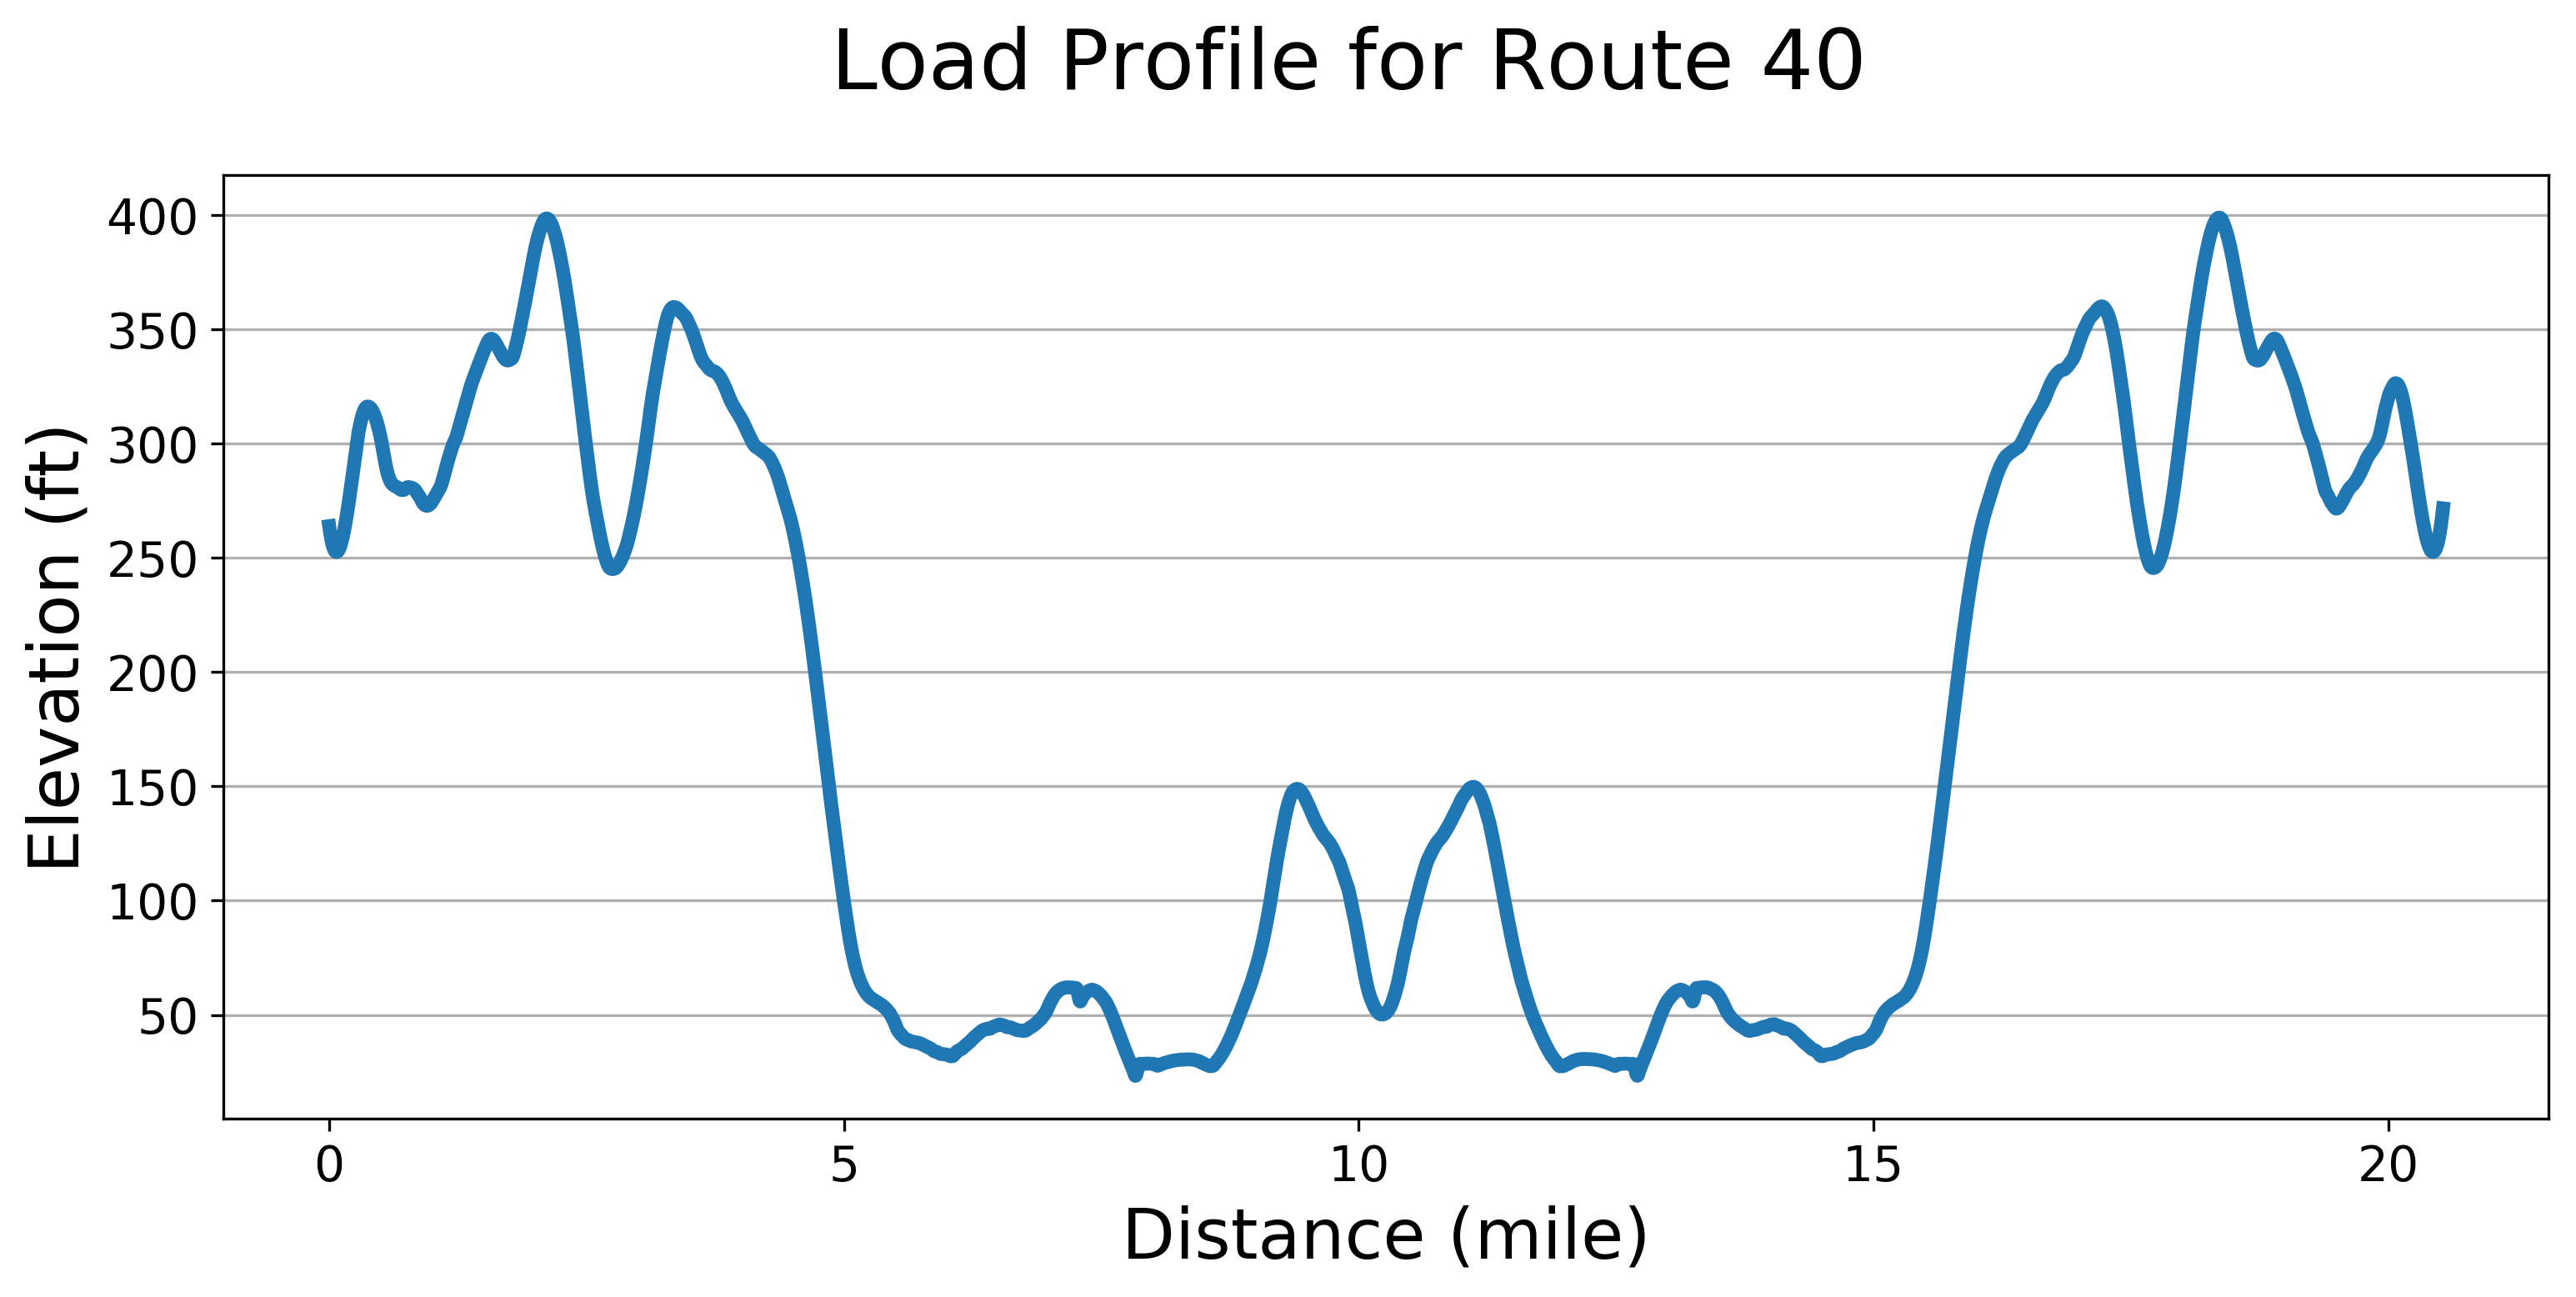

In [34]:
vis.profile_x(y_new2, route['length'], 40)

Questions:
* How to optimize the filter to smooth it more 
    * Filter out outliers first?
* If we filter out outliers, how to interpolate new points?

Lynna Plots PDF:
- elevation profile of unfiltered route
- elevation profile using SG
- grade profile of orginial and SG